# Table of Contents
 <p>

In [51]:
using Gadfly
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
plt.svg(true)
;

The purpose of this notebook is to see if we can use the functionality in julia's GaussianProcesses package to fit our model.

In [52]:
_n_per_region = 50
_n = _n_per_region*2
_thresh = 5.0
_Xgrid = linspace(0,10,_n_per_region*2)
;

In [53]:
# data-generating parameters
_σf2_star = 1.0
_Lstar  = 1.05
_τstar = 0.75
_βstar = 1.0
_σy2_star = 0.01
_region = _Xgrid.>_thresh
;

In [54]:
function kernel{T<:Number,Kern<:Kernel}(kern::Kern, x::AbstractVector{T})
    n = length(x)
    Xmat = reshape(x, (1,n))
    Σ = GaussianProcesses.crossKern(Xmat, kern)
    return Σ
end
function simulate1{T<:Number,S<:Number,Ker<:Kernel}(β::T, τ::T, kern::Ker, σy2::T, thresh::Real, X::AbstractVector{S})
    region = X.>thresh
    n = length(X)
    K = kernel(kern, X) + 1e-5*eye(n)
    fXdistr = MvNormal(zeros(n), K)
    fX = rand(fXdistr)
    In=eye(Diagonal{Float64},n)
    Z_Ydistr = Normal(0,√(σy2))
    Y = fX .+ β*X + τ*region .+ rand(Z_Ydistr, n)
    return Y
end

simulate1 (generic function with 1 method)

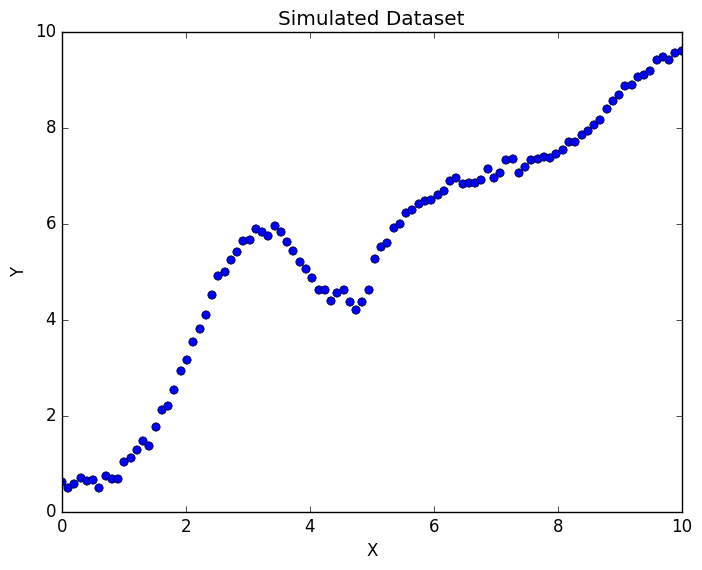

In [55]:
_σβ2 = 1000.0 # extremely diffuse normal prior on β
_στ2 = 1000.0 # extremely diffuse normal prior on τ
_kern = SE(log(_Lstar), log(√_σf2_star))
_II = _region * _region'
_Y = simulate1(_βstar, _τstar, _kern, _σy2_star, _thresh, _Xgrid)
plt.plot(_Xgrid, _Y, "o")
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

In [56]:
@doc """
# Description
Constructor for the Linear mean function
m(x) = xᵀβ
# Arguments:
* `β::Vector{Float64}`: One coefficient for each dimension
""" ->
type MeanDiscont <: GaussianProcesses.Mean
    β::Float64
    ref::Vector{Float64}  # separating hyperplane reference point
    norm::Vector{Float64} # separating hyperplane normal vector
    dim::Int
    function MeanDiscont(β::Float64, ref::Vector{Float64}, norm::Vector{Float64}, dim::Int) 
        if length(ref) == length(norm) == dim
            return new(β, ref, norm, dim)
        else
            return error("wrong dimensions")
        end
    end
end

In [57]:
function MeanDiscont(β::Float64, ref::Vector{Float64}, norm::Vector{Float64})
    return MeanDiscont(β, ref, norm, length(ref))
end
    
function GaussianProcesses.meanf(mDis::MeanDiscont,x::Matrix{Float64})
    which_side = (x'.-mDis.ref) * mDis.norm .> 0
    return which_side .* mDis.β
end

GaussianProcesses.get_params(mDis::MeanDiscont) = Float64[mDis.β]
GaussianProcesses.num_params(mDis::MeanDiscont) = 1

function GaussianProcesses.set_params!(mDis::MeanDiscont, hyp::Vector{Float64})
    length(hyp) == 1 || throw(ArgumentError("Discontinuity mean function only has 1 parameter"))
    mDis.β = hyp[1]
end

function GaussianProcesses.grad_meanf(mDis::MeanDiscont, x::Vector{Float64})
    dM_theta = dot(x.-mDis.ref, mDis.norm) > 0
    return [convert(Float64, dM_theta)]
end

grad_meanf (generic function with 6 methods)

In [58]:
_fitkern = SE(0.0,0.0)

Type: GaussianProcesses.SEIso, Params: [0.0,0.0]


In [59]:
_GPmean = MeanLin([1.0]) + MeanDiscont(0.75, [5.0], [1.0])

Type: GaussianProcesses.SumMean
  Type: GaussianProcesses.MeanLin, Params: [1.0]
  Type: MeanDiscont, Params: [0.75]


In [60]:
_logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
_gp = GP(collect(_Xgrid),_Y,_GPmean,_fitkern, _logObsNoise)

minimum eigenvalue0.

GP object:
  Dim = 1
  Number of observations = 100
  Mean function:
    Type: GaussianProcesses.SumMean
      Type: GaussianProcesses.MeanLin, Params: [1.0]
      Type: MeanDiscont, Params: [0.75]
  Kernel:
    Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Input observations = 
1x100 Array{Float64,2}:
 0.0  0.10101  0.20202  0.30303  0.40404  …  9.69697  9.79798  9.89899  10.0
  Output observations = [0.612086,0.487809,0.570081,0.69975,0.644759,0.653315,0.479354,0.733332,0.686596,0.682481  …  8.86896,8.89196,9.05506,9.10116,9.17116,9.40332,9.46003,9.40732,9.55518,9.58507]
  Variance of observation noise = 0.36787944117144233
  Marginal Log-Likelihood = -63.881

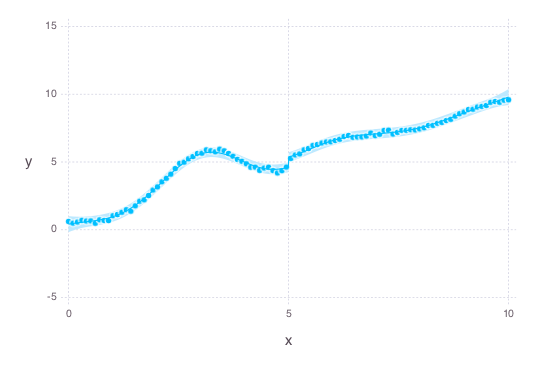

In [61]:
plot(_gp)

In [62]:
optimize!(_gp)

3678894411714117
logNoise-1.0
kernelType: GaussianProcesses.SEIso, Params: [0.0,0.0]

minimum eigenvalue of kernel-3.13711199546782e-14
minimum eigenvalue0.3678894411714117
logNoise-1.0
kernelType: GaussianProcesses.SEIso, Params: [0.0,0.0]

minimum eigenvalue of kernel-3.13711199546782e-14
minimum eigenvalue9.999999833628181e-6
logNoise-32.93205660667995
kernelType: GaussianProcesses.SEIso, Params: [3.3121185964458526,0.99236415702881]

minimum eigenvalue of kernel-2.0182417170328245e-13
minimum eigenvalue0.36186005484273615
logNoise-1.0165253661078564
kernelType: GaussianProcesses.SEIso, Params: [0.0017140760168719018,0.0005135648232499524]

minimum eigenvalue of kernel-3.077993911917471e-14
minimum eigenvalue0.0005961304494238994
logNoise-7.441968183182872
kernelType: GaussianProcesses.SEIso, Params: [0.6681862956728268,0.2001993922425079]

minimum eigenvalue of kernel-2.3014870569936856e-14
minimum eigenvalue0.11081232409018428
logNoise-2.2000075293454655
kernelType: GaussianProces

In [63]:
_gp.k

Type: GaussianProcesses.SEIso, Params: [0.30457549791807503,0.09125573207657392]


In [64]:
_kern

Type: GaussianProcesses.SEIso, Params: [0.04879016416943202,0.0]


In [65]:
_gp.logNoise

-3.936405130832006

In [66]:
log(_σy2_star)

-4.605170185988091

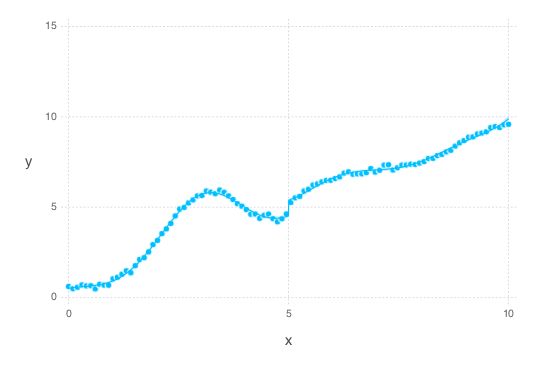

019528254349093985
logNoise-3.936405130832008
kernelType: GaussianProcesses.SEIso, Params: [0.30457549791807537,0.09125573207657392]

minimum eigenvalue of kernel-3.0369872709465373e-14
minimum eigenvalue0.019528254349093714
logNoise-3.936405130832003
kernelType: GaussianProcesses.SEIso, Params: [0.30457549791807476,0.09125573207657382]

minimum eigenvalue of kernel-3.017427963622379e-14
minimum eigenvalue0.019528254349094134
logNoise-3.936405130832006
kernelType: GaussianProcesses.SEIso, Params: [0.30457549791807503,0.09125573207657392]

minimum eigenvalue of kernel-3.0412722673582006e-14
minimum eigenvalue0.019528254349093218
logNoise-3.9364051308320067
kernelType: GaussianProcesses.SEIso, Params: [0.30457549791807514,0.09125573207657392]

minimum eigenvalue of kernel-3.0203110138395493e-14
minimum eigenvalue0.019528254349094165
logNoise-3.9364051308320063
kernelType: GaussianProcesses.SEIso, Params: [0.3045754979180751,0.09125573207657392]

minimum eigenvalue of kernel-3.01209582375

In [67]:
plot(_gp)

In [68]:
@doc """
# Description
Constructor for the isotropic linear kernel (covariance)
k(x,x') = xᵀx'/ℓ²
# Arguments:
* `ll::Float64`: Log of the length scale ℓ
""" ->
type Discont <: Kernel
    lσβ2::Float64      # Discontinuity
    ref::Vector{Float64}  # separating hyperplane reference point
    norm::Vector{Float64} # separating hyperplane normal vector
    function Discont(lσβ2::Float64, ref::Vector{Float64}, norm::Vector{Float64})
        if length(ref) != length(norm)
            throw(ArgumentError("Dimensions of reference and normal vector should be the same"))
        end
        return new(lσβ2, ref, norm)
    end
end

function above(disc::Discont, x::Vector{Float64})
    dot(x.-disc.ref, disc.norm) > 0
end

function GaussianProcesses.kern(disc::Discont, x::Vector{Float64}, y::Vector{Float64})
    if above(disc, x) && above(disc, y)
        return exp(disc.lσβ2)
    else
        return 0.0
    end
end

GaussianProcesses.get_params(disc::Discont) = Float64[disc.lσβ2]
GaussianProcesses.num_params(disc::Discont) = 1

function GaussianProcesses.set_params!(disc::Discont, hyp::Vector{Float64})
    length(hyp) == 1 || throw(ArgumentError("Linear isotropic kernel only has one parameter"))
    disc.lσβ2 = hyp[1]
end

function GaussianProcesses.grad_kern(disc::Discont, x::Vector{Float64}, y::Vector{Float64})
    return kern(disc, x, y)
end

grad_kern (generic function with 19 methods)

In [69]:
GaussianProcesses.ConstKernel

GaussianProcesses.ConstKernel

In [70]:
_fullkern = SE(0.0,0.0) + 
    GaussianProcesses.ConstKernel(LinIso(-1.0)) + 
    GaussianProcesses.ConstKernel(Discont(10.0, [5.0], [1.0]))

Type: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Type: GaussianProcesses.ConstKernel
    Type: GaussianProcesses.LinIso, Params: [-1.0]
  Type: GaussianProcesses.ConstKernel
    Type: Discont, Params: [10.0]


In [71]:
_GPmean = MeanZero()

Type: GaussianProcesses.MeanConst, Params: [0.0]


In [72]:
_logObsNoise = -1.0                        # log standard deviation of observation noise (this is optional)
_fullgp = GP(collect(_Xgrid),_Y,_GPmean,_fullkern, _logObsNoise)

minimum eigenvalue0.

GP object:
  Dim = 1
  Number of observations = 100
  Mean function:
    Type: GaussianProcesses.MeanConst, Params: [0.0]
  Kernel:
    Type: GaussianProcesses.SumKernel
      Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
      Type: GaussianProcesses.ConstKernel
        Type: GaussianProcesses.LinIso, Params: [-1.0]
      Type: GaussianProcesses.ConstKernel
        Type: Discont, Params: [10.0]
  Input observations = 
1x100 Array{Float64,2}:
 0.0  0.10101  0.20202  0.30303  0.40404  …  9.69697  9.79798  9.89899  10.0
  Output observations = [0.612086,0.487809,0.570081,0.69975,0.644759,0.653315,0.479354,0.733332,0.686596,0.682481  …  8.86896,8.89196,9.05506,9.10116,9.17116,9.40332,9.46003,9.40732,9.55518,9.58507]
  Variance of observation noise = 0.36787944117144233
  Marginal Log-Likelihood = -72.681

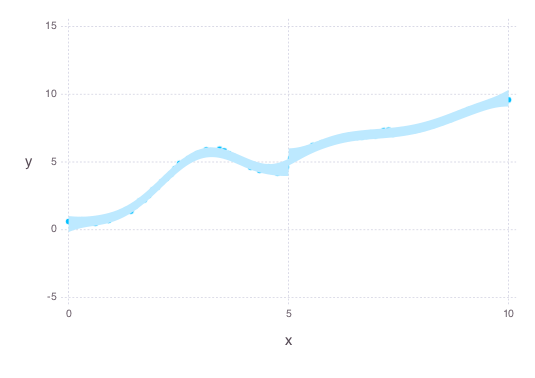

36788944108460236
logNoise-1.0
kernelType: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [0.0,0.0]
  Type: GaussianProcesses.ConstKernel
    Type: GaussianProcesses.LinIso, Params: [-1.0]
  Type: GaussianProcesses.ConstKernel
    Type: Discont, Params: [10.0]

minimum eigenvalue of kernel-9.728880820317657e-11


In [73]:
plot(_fullgp)

In [77]:
@time optimize!(_fullgp)

minimum eigenvalue0.0231354091190075
logNoise-3.76682329765332
kernelType: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [0.3494255058276905,0.06735209481073497]
  Type: GaussianProcesses.ConstKernel
    Type: GaussianProcesses.LinIso, Params: [-1.0]
  Type: GaussianProcesses.ConstKernel
    Type: Discont, Params: [10.0]

minimum eigenvalue of kernel-1.0894517347394301e-10
minimum eigenvalue2.3207670997582073e83
logNoise-4.734089311277604
kernelType: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [-49.54255798422746,95.97823024799001]
  Type: GaussianProcesses.ConstKernel
    Type: GaussianProcesses.LinIso, Params: [-1.0]
  Type: GaussianProcesses.ConstKernel
    Type: Discont, Params: [10.0]

minimum eigenvalue of kernel2.3207670997582073e83
minimum eigenvalue1.0069417116616415e46
logNoise-4.300277711014792
kernelType: GaussianProcesses.SumKernel
  Type: GaussianProcesses.SEIso, Params: [-27.166375121140035,52.962916003315485]
  Type: Gauss

In [78]:
GaussianProcesses.get_params(_fullgp)

4-element Array{Float64,1}:
 -5.66349 
 -8.38232 
  0.245102
  0.785319

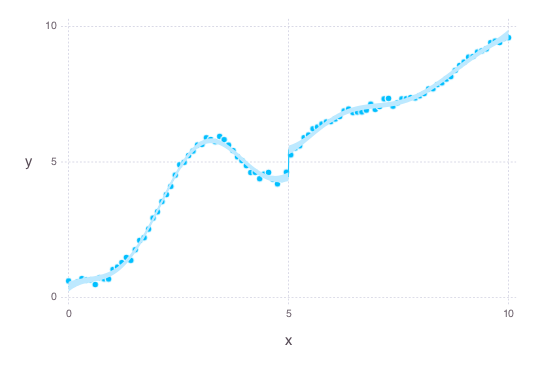

BFGS
 * Starting Point: [-1.0,0.0,0.0,0.0]
 * Minimum: [-3.76682329765332,-6.775684480877897, ...]
 * Value of Function at Minimum: 15.187262
 * Iterations: 7
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < 1.0e-08: false
   * Exceeded Maximum Number of Iterations: false
 * Objective Function Calls: 96
 * Gradient Call: 96

In [76]:
plot(_fullgp)

I think this is what we want! Hurray! Out of interest, let's look at how the Gaussian Process is implemented here, compared to my homegrown version. The main prediction functions is copy-pasted below:

In [ ]:
function _predict(gp::GP, x::Array{Float64})
    cK = crossKern(x,gp.x,gp.k)
    Lck = whiten(gp.cK, cK')
    mu = meanf(gp.m,x) + cK*gp.alpha    # Predictive mean
    Sigma = crossKern(x,gp.k) - Lck'Lck # Predictive covariance
    Sigma = max(Sigma,0)
    return (mu, Sigma)
end

OK, so we start by computing the covariance matrix between the training points and the prediction points. Then we apply a [whitening transformation](https://en.wikipedia.org/wiki/Whitening_transformation). I think that basically boils down to finding a square root of the covariance matrix, and then normalizing, usually the symmetric square root.

In [147]:
function τposterior(gp::GP, τkern::Discont)
    ΣYY = gp.cK
    above = τkern.ref .+ τkern.norm
    above_mat = above''
    ΣτY = GaussianProcesses.crossKern(above_mat, gp.x,  τkern)
    Lck = PDMats.whiten(ΣYY, ΣτY')
    muτ_post = ΣτY*gp.alpha
    @assert length(muτ_post)==length(above)
#     στ2 = exp(τkern.lσβ2)
    στ2 = GaussianProcesses.kern(τkern, above, above)
    Στ_post = στ2 - Lck'Lck
    @assert size(Στ_post)==(length(above),length(above))
    return Normal(muτ_post[1], √Στ_post[1])
end

τposterior (generic function with 1 method)